# FIAM Hackathon

## Table of Contents
<hr style="border: 0.25px solid black;">

- [1. Data Preparation](#section-1)
  * [1.1 Drop Uninformative Features](#subsection-11)
  * [1.2 Drop Forward-Looking Features](#subsection-12)
  * [1.3 Drop Observations with Missing Tickers](#subsection-13)
  * [1.4 Filter for the Most Traded Stocks Per Month](#subsection-14) 
  * [1.5 Mapping Stocks to their SIC code](#subsection-15) 
  * [1.6 Dummy Variables : Month and Industry](#subsection-16) 
$$$$
- [2. Custom Time Series CV](#section-2)
  * [2.1 Rolling Fixed Window : Avoid Lookahead Bias](#subsection-21) 
  * [2.2 Testing the RollingTimeSeriesCV Class](#subsection-22)
$$$$
- [3. Feature Selection](#section-3)
  * [3.1 Multivariate Feature Selection : Capturing Feature Interdependencies](#subsection-31) 
  * [3.2 Univariate Feature Selection : Diving into Individual Relationships](#subsection-32)
$$$$
- [5. Predicting With Tree Models](#section-5)
  * [5.1 Custom Validation Score : Information Coefficient](#subsection-51)
  * [5.2 RollingTimeSeriesCV : Parameter Options](#subsection-52)
  * [5.3 LightGBM Graadient Boosting : Hyperparameter Options](#subsection-53)
  * [5.4 Tree Tuning](#subsection-54) 

## Import the Necessary Libraries
<hr style="border: 0.25px solid black;">

In [1]:
import pandas as pd 
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy as sp 
import lightgbm as lgb 
import itertools 
from sklearn import preprocessing, decomposition, model_selection, linear_model, feature_selection, ensemble, metrics  

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg") 

## Load the Data
<hr style="border: 0.25px solid black;">

**Preliminary Data Cleaning and Formatting** :
> 1. Replace all NA values with the cross-section median 

> 2. Convert dates to datetime type with yyyy-mm format 

> 3. Sort dates and then stock tickers in ascending order

In [3]:
ticker_data = pd.read_csv("C:/Users/khail/OneDrive/Desktop/Github Projects/hackathon_data.csv", parse_dates = ["date"])

## Variable Explanation 
<hr style="border: 0.25px solid black;">

- **age** : Firm age
- **aliq_at** : Liquidity of book assets 
- **aliq_mat** : Liquidity of market assets 
- **ami_126d** : Amihud measure
- **at_be** : Book leverage
- **at_gr1** : Asset growth 
- **at_me** : Assets-to-market
- **at_turnover** : Capital turnover 

- **be_gr1a** : Change in common equity
- **be_me** : Book-to-market equity
- **beta_60m** : Market beta
- **beta_dimson_21d** : Dimson beta
- **betabab_1260d** : Frazzini-Pedersen market beta
- **betadown_252d** : Downside beta
- **bev_mev** : Book-to-market enterprise value 
- **bidaskhl_21d** : High-low bid-ask spread

- **capex_abn** : Abnormal corporate investment
- **capx_gr1** : CAPEX growth (1 year)
- **capx_gr2** : CAPEX growth (2 years)
- **capx_gr3** : CAPEX growth (3 years)
- **cash_at** : Cash-to-assets 
- **chcsho_12m** : Net stock issues 
- **coa_gr1a** : Change in current operating assets 
- **col_gr1a** : Change in current operating liabilities
- **cop_at** : Cash-based operating profits-to-book assets
- **cop_atl1** : Cash-based operating profits-to-lagged book assets
- **corr_1260d** : Market correlation
- **coskew_21d** : Coskewness
- **cowc_gr1a** : Change in current operating working capital 

- **dbnetis_at** : Net debt issuance
- **debt_gr3** : Growth in book debt (3 years)
- **debt_me** : Debt-to-market 
- **dgp_dsale** : Change gross margin minus change sales
- **div12m_me** : Dividend yield
- **dolvol_126d** : Dollar trading volume (126 days)
- **dolvol_var_126d** : Coefficient of variation for dollar trading volume
- **dsale_dinv** : Change sales minus change Inventory
- **dsale_drec** : Change sales minus change receivables
- **dsale_dsga** : Change sales minus change SG&A

- **earnings_variability** : Earnings variability
- **ebit_bev** : Return on net operating assets
- **ebit_sale** : Profit margin
- **ebitda_mev** : Ebitda-to-market enterprise value
- **emp_gr1** : Hiring rate
- **eq_dur** : Equity duration
- **eqnetis_at** : Net equity issuance
- **eqnpo_12m** : Equity net payout
- **eqnpo_me** : Net payout yield
- **eqpo_me** : Payout yield

- **f_score** : Pitroski F-score
- **fcf_me** : Free cash flow-to-price
- **fnl_gr1a** : Change in financial liabilities
- **gp_at** : Gross profits-to-assets 
- **gp_atl1** : Gross profits-to-lagged assets

- **intrinsic_value** : Intrinsic value-to-market
- **inv_gr1** : Inventory growth
- **inv_gr1a** : Inventory change
- **iskew_capm_21d** : Idiosyncratic skewness from CAPM
- **iskew_ff3_21d** : Idiosyncratic skewness from the Farma-French 3-factor model
- **iskew_hxz4_21d** : Idiosyncratic skewness from the q-factor model 
- **ivol_capm_21d** : Idiosyncratic volatility from the CAPM (21 days)
- **ivol_capm_252d** : Idiosyncratic volatility from the CAPM (252 days)
- **ivol_ff3_21d** : Idiosyncratic volatility from the Farma-French 3-factor model 
- **ivol_hxz4_21d** : Idiosyncratic volatility from the q-factor model

- **kz_index** : Kaplan-Zingales index
- **lnoa_gr1a** : Change in long-term net operating assets 
- **lti_gr1a** : Change in long-term investments 
- **market_equity** : Market equity 
- **mispricing_mgmt** : Mispricing factor : Management
- **mispricing_perf** : Mispricing factor : Performance 
- **month** : Month 
- **mspread** : Market spread

- **ncoa_gr1a** : Change in non-current operating assets
- **ncol_gr1a** : Change in non-current operating liabilities
- **netdebt_me** : Net debt-to-price 
- **netis_at** : Net total issuance 
- **nfna_gr1a** : Change in net financial assets 
- **ni_ar1** : Earnings persistence 
- **ni_be** : Return on equity 
- **ni_inc8q** : Number of consecutive quarters with earnings increases 
- **ni_ivol** : Earnings volatility 
- **ni_me** : Earnings to price 
- **niq_at** : Quarterly return on assets 
- **niq_at_chg1** : Change in quarterly return on assets 
- **niq_be** : Quarterly return on equity 
- **niq_be_chg1** : Change in quarterly return on equity 
- **niq_su** : Standardized earnings surprise 
- **nncoa_gr1a** : Change in net operating assets 
- **noa_at** : Net operating assets 
- **noa_gr1a** : Change in net operating assets 

- **o_score** : Ohlson O-score
- **oaccruals_at** : Operating accruals 
- **oaccruals_ni** : Percent operating accruals 
- **ocf_at** : Operating cash flow to assets 
- **ocf_at_chg1** : Change in operating cash flow to assets 
- **ocf_me** : Operating cash fow to market equity 
- **ocfq_saleq_std** : Standard deviation of operating cash flow to sales (quarterly)
- **op_at** : Operating profit to assets
- **op_atl1** : Operating profit to lagged assets 
- **ope_be** : Operating profit to book equity 
- **ope_bel1** : Operating profit to lagged book equity 
- **opex_at** : Operating expenses to assets 

- **pi_nix** : Pre-tax income (excluding extraordinary items)
- **ppeinv_gr1a** : PPE investments growth (1-year)
- **prc** : Price
- **prc_highprc_252d** : Price to 252-Day high 
- **qmj** : Quality minus junk 
- **qmj_growth** : Quality minus junk, growth subcomponent
- **qmj_prof** : Quality minus junk, profitability subcomponent
- **qmj_safety** : Quality minus junk, safety subcomponent

- **rd5_at** : Research and Development (5-year average) to assets
- **rd_me** : Research and Development to market equity
- **rd_sale** : Research and Development to sales
- **resff3_12_1** : Residual of the Fama-French 3-factor model (12-month, 1-month lag)
- **resff3_6_1** : Residual of the Fama-French 3-factor model (6-month, 1-month lag)
- **ret_1_0** : 1-month return 
- **ret_3_1** : 3-month return (excluding last month)
- **ret_6_1** : 6-month return (excluding last month)
- **ret_9_1** : 9-month return (excluding last month)
- **ret_12_1** : 12-month return (excluding last month)
- **ret_12_7** : 6-month return (7 to 12 months ago)
- **ret_60_12** : 5-year return (excluding last year)
- **rmax1_21d** : Maximum daily return (21 days)
- **rmax5_21d** : Maximum 5-day return (21 days)
- **rmax5_rvol_21d** : Maximum 5-day return to realized volatility (21 days)
- **rskew_21d**: Return skewness (21 days)
- **rvol_21d** : Realized volatility (21 days)

- **sale_bev** : Sales to book equity 
- **sale_emp_gr1** : Sales to employee growth (1 year)
- **8sale_gr1** : Sales growth (1 year)
- **sale_gr3** : Sales growth (3 year)
- **sale_me** : Sales to market equity
- **saleq_gr1** :  Quarterly sales growth (1 year)
- **saleq_su** : Sales surprise (quarterly)
- **seas_1_1an** : Seasonality 1-Year 
- **seas_1_1na** : Seasonality 1-Year 
- **seas_2_5an** : Seasonality 2-Year to 5-Year 
- **seas_2_5na** : Seasonality 2-Year to 5-Year  
- **sti_gr1a** : Short-term investment growth (1 year) 

## 1. Data Preparation
<hr style="border: 0.25px solid black;">

### 1.1 Drop Uninformative Features 

**Justification** :
> 1. Share code refers to the class of shares, which is all common equity in our dataset. Therefore, we drop this unary feature.

> 2. There are 2 main exchanges in the US

In [4]:
ticker_data.drop(columns = ["exchcd", "shrcd"], inplace = True)

### 1.2 Drop Forward Looking Features 

**Justification** :
> 1. Actual and estimated eps are for the next quarter. Pulling them back to the current quarter will result in NA values due to changing tickers.

> 2. The target variable is the next month's excess returns. We aim to determine, rather than forecast, fundamentals that lead to higher returns.

In [5]:
ticker_data.drop(columns = ["eps_medest", "eps_meanest", "eps_stdevest", "eps_actual"], inplace = True)

### 1.3 Drop Observations with Missing Tickers

In [6]:
ticker_data.dropna(subset = ["stock_ticker"], inplace = True)

### 1.4 Filter for the Most Traded Stocks Per Month 

**Justification** :
> 1. Reduce the *variability* in the ticker list, and thus feature interaction

> 2. Reduce the number of rows to accelerate model training & tuning 

> 3. Ensure *enough volume* to execute orders for monthly rebalancing   

> 4. *Fundamentals* hold better for stocks which the market trades a lot 

In [7]:
ticker_data = ticker_data.sort_values(by = ["date", "dolvol_126d"], ascending = [True, False])
ticker_data = ticker_data.groupby("date").head(400).reset_index(drop = True)

### 1.5 Mapping Stocks to their SIC code 

**SIC Code First 2 Digits** :
- `0-9` : Agriculture, Forestry, and Fishing
$$$$
- `10-14` : Mining 
$$$$
- `20-39` : Manufacturing
$$$$
- `40-49` : Transportation and Utilities 
$$$$
- `50-51` : Wholesale Trade 
$$$$
- `52-59` : Retail Trade 
$$$$
- `60-67` : Finance, Insurance, and Real Estate 
$$$$
- `70-89` : Services 
$$$$
- `91-97` : Public Administration 
$$$$
- `99` : Nonclassifiable 

In [8]:
ticker_mapper = pd.read_csv("C:/Users/khail/OneDrive/Desktop/Github Projects/ticker_mapper.csv")
ticker_mapper_dict = dict(zip(ticker_mapper["stock_ticker"], ticker_mapper["sic"]))

In [9]:
ticker_data["sic"] = ticker_data["stock_ticker"].map(ticker_mapper_dict).astype("str")
ticker_data["sic"] = ticker_data["sic"].str[:2]

In [10]:
def assign_industry(sic_code) :
    if sic_code == "na" :
        return "Missing"
    
    elif 1 <= int(sic_code) <= 9 :
        return 'Agriculture, Forestry, and Fishing'
    
    elif 10 <= int(sic_code) <= 14 :
        return "Mining" 
    
    elif 15 <= int(sic_code) <= 17 :
        return "Construction"
    
    elif 20 <= int(sic_code) <= 39 :
        return "Manufacturing"
    
    elif 40 <= int(sic_code) <= 49 :
        return "Transportation and Utilities"
    
    elif 50 <= int(sic_code) <= 51 :
        return "Wholesale Trade"
    
    elif 52 <= int(sic_code) <= 59 :
        return "Retail Trade"
    
    elif 60 <= int(sic_code) <= 67 :
        return "Finance, Insurance, and Real Estate"
    
    elif 70 <= int(sic_code) <= 89 :
        return "Services"
    
    elif 91 <= int(sic_code) <= 97 :
        return "Public Administration"
    
    elif int(sic_code) == 99 :
        return "Nonclassifiable"

In [11]:
ticker_data["sic_industry"] = ticker_data["sic"].apply(assign_industry)
ticker_data.drop(columns = ["sic"], inplace = True)

### 1.6 Dummy Variables : Month & Industry 

In [12]:
month_mapper = {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 
                7 : "Jul", 8 : "Aug", 9 : "Sept", 10 : "Oct", 11 : "Nov", 12 : "Dec"}

In [13]:
ticker_data = pd.get_dummies(ticker_data , columns = ["month"], drop_first = True, dtype = "int", prefix = "", prefix_sep = "")

In [14]:
ticker_data = pd.get_dummies(ticker_data , columns = ["sic_industry"], drop_first = True, dtype = "int", prefix = "", prefix_sep = "")

## 2. Custom Time Series CV 
<hr style="border: 0.25px solid black;">

- `In-Sample Period` : 2000-01 to 2009-12 (120 months)
$$$$
- `Out-of-Sample Period` : 2010-01 to 2023-12 (168 months)

In [15]:
ticker_data["date"] = ticker_data["date"].dt.strftime("%Y-%m")
ticker_train = ticker_data[(ticker_data["date"] >= "2000-01") & (ticker_data["date"] < "2010-01")].set_index("date")
ticker_test = ticker_data[(ticker_data["date"] >= "2010-01")].set_index("date")

### 2.1 Rolling Fixed Window : Avoid Lookahead Bias

**Rationale** :
> 1. `Lookahead bias` : adding a gap of n month(s) between the training and validation sets of each split prevents data leakage, and therefore overly optimistic performance estimates. Since financial data  is time-dependent, using directly adjacent months for training and validation will allow the model to learn from future information at t + 1 contained in data at month t. The model's predictions will not be out-of-sample.
$$$$
> 2. `Custom Training and Validation` : we can iterate through different durations for the training, validation & lookahead periods, as well as for the number of splits, to add an upper layer of cross validation precision when tuning a model's hyperparameters with GridSearchCV.  

**Cross-Validation parameters** :
> 1. `train_duration` : number of months used for training 
$$$$
> 2. `test_duration` : number of months used for validation 
$$$$
> 3. `lookahead` : number of months between the training and validation sets to avoid data leakage 
$$$$
> 4. `n_splits` : number of training-validation sets, with the roll forward period == `test_duration`

**Rule for selection of CV parameters** :
> $\text{train_duration} + \text{test_duration} \times \text{n_splits} + \text{lookahead} <= \text{total number of months in the training set}$
$$$$
> $\text{n_splits} = \frac{(\text{n_valid_years } \times 12)}{\text{ test_duration}}$ 

In [16]:
class RollingTimeSeriesCV :
    
    def __init__(self, train_duration, valid_duration, lookahead, n_splits) :
        """
        Initialize the time series cross-validation splitter 
        
        Parameters :
        - train_duration : int, number of months in the training period
        - valid_duration : int, number of months in the validation period
        - lookahead : int, the number of months between the end of the training period and the start of the validation period
        - n_splits : int, the number of splits (folds) for cross-validation
        """
        self.valid_duration = valid_duration 
        self.train_duration = train_duration 
        self.lookahead = lookahead
        self.n_splits = n_splits

    def split(self, X, y = None, groups = None) :
        """
        Generate indices for training and validation splits.

        Parameters :
        - X : DataFrame, feature set with a datetime index
        - y : Series or DataFrame, optional, the target variable (not used in this method)
        - groups : None, optional, not used in this method
        
        Yields:
        - train_indices: array, indices of the training portion of each split 
        - valid_indices: array, indices of the validation portion of each split 
        """
        # Get the unique dates from the index (assuming monthly data) and sort them in descending order 
        unique_dates = X.index.unique( )  
        months = sorted(unique_dates, reverse = True)   
        
        for i in range(self.n_splits) :
            
            # Calculate the index for the end of the validation period
            valid_end_idx = i * self.valid_duration
            if valid_end_idx >= len(months) :
                break 
            split_valid_end = months[valid_end_idx] 
            
            # Calculate the index for the start of the validation period
            valid_start_idx = valid_end_idx + self.valid_duration - 1
            if valid_start_idx >= len(months) :
                break 
            split_valid_start = months[valid_start_idx] 
            
            # Calculate the index for the end of the training period
            train_end_idx = valid_start_idx + 1 + self.lookahead 
            if train_end_idx >= len(months) :
                break
            split_train_end = months[train_end_idx] 
            
            # Calculate the index for the start of the training period
            train_start_idx = train_end_idx + self.train_duration - 1 
            if train_start_idx >= len(months) :
                break 
            split_train_start = months[train_start_idx]
            
            # Convert the index to a numpy array for boolean indexing
            idx_array = X.index.to_numpy( )
            # Create boolean arrays for selecting the training and validation indices
            train_idx = (idx_array >= split_train_start) & (idx_array <= split_train_end)
            valid_idx = (idx_array >= split_valid_start) & (idx_array <= split_valid_end)
        
            # Get the integer positions of the selected training and validation indices
            train_indices = np.where(train_idx)[0]
            valid_indices = np.where(valid_idx)[0]
            
            # Yield the train and validation indices for this split
            yield train_indices, valid_indices    
        
    def get_n_splits(self, X, y, groups = None) :
        return self.n_splits

### 2.2 Testing the RollingTimeSeriesCV Class

In [17]:
test_cv = RollingTimeSeriesCV(train_duration = 60, valid_duration = 6, lookahead = 1, n_splits = 8)

In [18]:
for split_train_idx, split_valid_idx in test_cv.split(X = ticker_train) :
    
    train_dates = ticker_train.index[split_train_idx]
    valid_dates = ticker_train.index[split_valid_idx]
    
    # Print the dates for train and validation sets
    print(f"Train dates: {train_dates}")
    print("")
    print(f"Validation dates: {valid_dates}")
    print("")
    
    #print(f"Train : {split_train_idx}, Test : {split_valid_idx}")
    #print("")

Train dates: Index(['2004-06', '2004-06', '2004-06', '2004-06', '2004-06', '2004-06',
       '2004-06', '2004-06', '2004-06', '2004-06',
       ...
       '2009-05', '2009-05', '2009-05', '2009-05', '2009-05', '2009-05',
       '2009-05', '2009-05', '2009-05', '2009-05'],
      dtype='object', name='date', length=24000)

Validation dates: Index(['2009-07', '2009-07', '2009-07', '2009-07', '2009-07', '2009-07',
       '2009-07', '2009-07', '2009-07', '2009-07',
       ...
       '2009-12', '2009-12', '2009-12', '2009-12', '2009-12', '2009-12',
       '2009-12', '2009-12', '2009-12', '2009-12'],
      dtype='object', name='date', length=2400)

Train dates: Index(['2003-12', '2003-12', '2003-12', '2003-12', '2003-12', '2003-12',
       '2003-12', '2003-12', '2003-12', '2003-12',
       ...
       '2008-11', '2008-11', '2008-11', '2008-11', '2008-11', '2008-11',
       '2008-11', '2008-11', '2008-11', '2008-11'],
      dtype='object', name='date', length=24000)

Validation dates: Index(['2

## 3. Feature Selection 
<hr style="border: 0.25px solid black;">

**Rationale** :
> 1. `Random forest` : capture non-linear relationship between features, and between each feature and the target variable 
$$$$
> 2. `Mutual information` : capture non-linear dependency between each feature and the target variable (based on entropy estimation)

In [19]:
# Drop the columns "stock_ticker"
X_train = ticker_train.drop(columns = ["stock_ticker", "stock_exret"])
y_train = ticker_train["stock_exret"].copy( )

In [20]:
X_test = ticker_test.drop(columns = ["stock_ticker", "stock_exret"])
y_test = ticker_test["stock_exret"].copy( )

### 3.1 Multivariate Feature Selection : Capturing Feature Interdependencies

In [21]:
def multivariate_feat_select(X, y, n_features = 30) :
    """
    Perform multivariate feature selection using a RandomForestRegressor to identify the top N important features 
    
    Parameters:
    - X : DataFrame, the feature set 
    - y : Series, the target variable
    - n_features : int, default = 30, the number of top features to select based on feature importance
    
    Returns:
    - top_feats_imps : Series, the top N most important features with their importance scores
    """
    # Initialize the RandomForestRegressor with all available CPU cores and a fixed random seed for reproducibility
    # Fit the RandomForestRegressor to the provided data
    rf_reg = ensemble.RandomForestRegressor(random_state = 42, n_jobs = -1)
    rf_reg.fit(X, y)    
    
    # Create a pandas Series to store feature importances, indexed by the feature names
    # Select the top N most important features
    # Plot the top N features' importances as a horizontal bar chart
    top_feats_imps = pd.Series(rf_reg.feature_importances_, index = X.columns).nlargest(n_features)
    top_feats_imps.plot(kind = "barh", figsize = (10, 15), xlabel = "Feature Importance")
    plt.show( )
    
    # Return the Series containing the top N features and their importance scores
    return top_feats_imps 

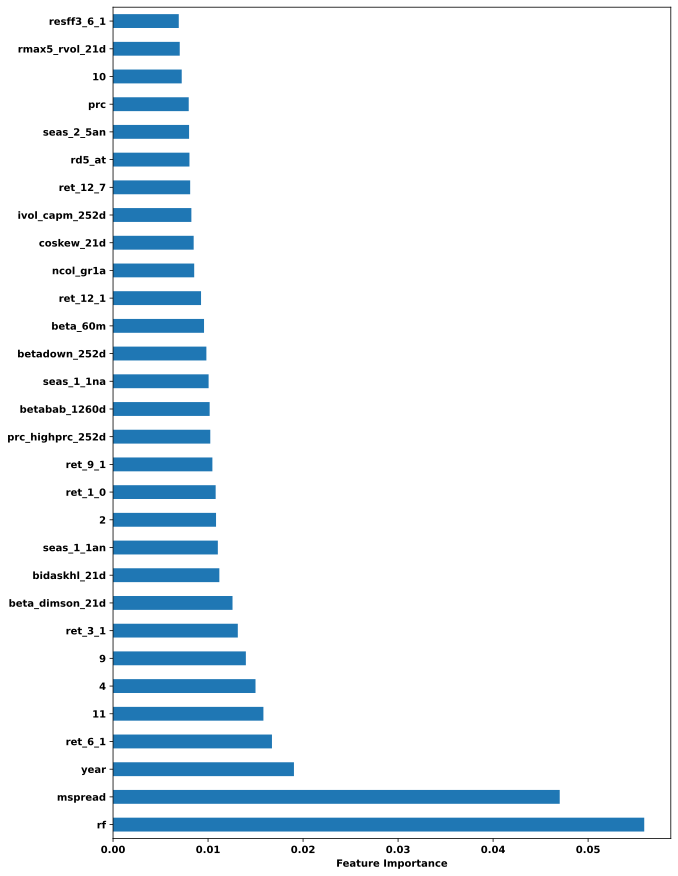

In [22]:
rf_feats_imps = multivariate_feat_select(X_train, y_train)

In [23]:
top_feats = rf_feats_imps.index
X_train = X_train[top_feats] 
X_test = X_test[top_feats]

### 3.2 Univariate Feature Selection : Drilling Into Individual Relationships

In [24]:
def univariate_feat_select(X, y, method, n_features = 30) :
    """
    Perform univariate feature selection based on the specified method and select the top N important features 
    
    Parameters:
    - X : DataFrame, the feature set
    - y : Series, the target variable
    - method : str, the method used for feature selection ('mutual_info' or 'spearmanr')
    - n_features : int, default = 30, the number of top features to select based on the chosen method
    
    Returns:
    - top_feats_scores : Series, the top N most important features with their scores
    """
    # Standardize the feature set to ensure all features have a mean of 0 and a standard deviation of 1
    std_scaler = preprocessing.StandardScaler( )
    X_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns = X.columns)
    
     # If method is "mutual_info", use mutual information regression to rank the features 
    if method == "mutual_info" :
        # Select the top N features based on mutual information regression scores
        selector = feature_selection.SelectKBest(score_func = feature_selection.mutual_info_regression, k = n_features)
        selector.fit(X_scaled, y)
        feats_scores = selector.scores_
    
    # If method is "spearmanr", use Spearman rank correlation to rank the features
    elif method == "spearmanr" :
        # Calculate the absolute value of Spearman correlation for each feature
        corr_scores = [ ]
        for col in X_scaled.columns :
            corr, _ = sp.stats.spearmanr(X_scaled[col], y)
            corr_scores.append(abs(corr))
        feats_scores = corr_scores 
    
    # Create a Series to store the feature scores, indexed by feature names
    # Select the top N most important features 
    # Plot the top N features' scores as a horizontal bar chart
    top_feats_scores = pd.Series(feats_scores, index = X_scaled.columns).nlargest(n_features)
    top_feats_scores.plot(kind = "barh", figsize = (10, 15), xlabel = method)
    plt.show( )
    
    # Return the Series containing the top N features and their feature scores
    return top_feats_scores 

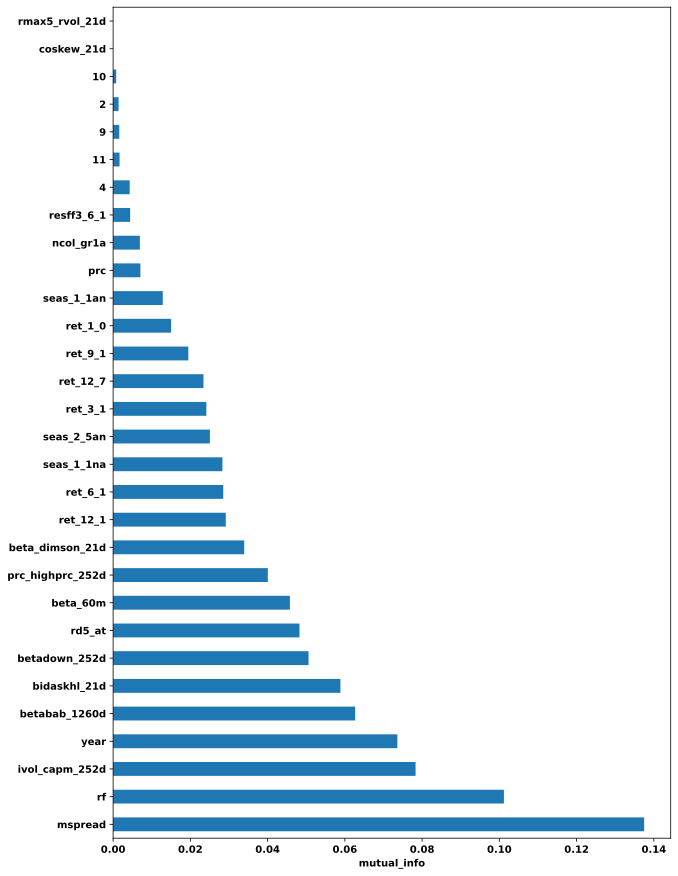

In [25]:
mutual_info_feats_scores = univariate_feat_select(X_train, y_train, method = "mutual_info")

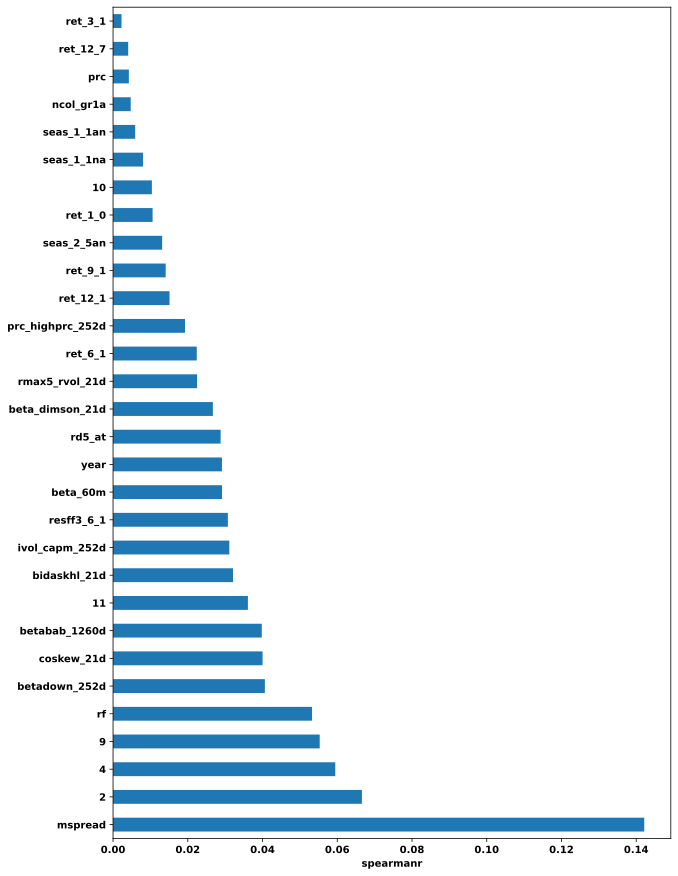

In [26]:
spearmanr_feats_scores = univariate_feat_select(X_train, y_train, method = "spearmanr")

## 4. Predicting Next Month's Excess Returns : Linear Models 

## 5. Predicting Next Month's Excess Returns With Tree Models 

**Convergence Process** :
- Boosted ensemble models consist of training hundreds of weak base estimators sequentially to reduce the bias of the combined estimator. 
$$$$
- Each weak tree learns rules to partition the feature space into specific decision regions and improves iteratively from the previous weak tree. 
$$$$
- The final ensemble prediction is the average of predicted values across all base learners, with higher weight assigned to "stronger learners". 
$$$$
- Overfitting is controlled through regularization at the base learners' level and at the ensemble level with shrinkage (using the learning rate).

**Key Strengths** :
> 1. `Reduced risk of overfitting` : independent trees, via random row and column sampling, reduce correlation in prediction errors 
$$$$
> 2. `Robust to minor variations` : combined predictions minimize generalization error and prevent wide swings in the trees' structure
$$$$
> 3. `Minimal data preparation` : tree make no strong assumptions about the data, need no scaling, and are less sensitive to outliers
$$$$
> 4. `Non-linearity` : rather than focus on the impact of features on the target, trees look at how feature values lead to specific decisions
$$$$
> 5. `Interpretability` : relationship between features and the target variable can be interpreted through feature importance & Shapley 
$$$$
> 6. `Feature ranking` : significant features are used more frequently & higher up in each tree, and contribute more to reducing the loss

### 5.1 Custom Validation Score : Information Coefficient 

In [27]:
def info_coef(y, y_pred) :
    return sp.stats.spearmanr(y, y_pred)[0]

In [28]:
info_coef_scorer = metrics.make_scorer(info_coef)

### 5.2 RollingTimeSeriesCV : Parameter Options 

In [29]:
train_duration_options = [60, 66, 72]
valid_duration_options = [6, 9]
lookahead = 1 

In [30]:
# Initialize an empty list to store the time series training-validation combinations
tscv_combinations = [  ]

# Use itertools.product to iterate over all possible combinations of training duration and validation duration
for train_duration, valid_duration in itertools.product(train_duration_options, valid_duration_options) :
    
    # Assuming that we cross-validate over 48 months, divide by the validation duration to determine the number of splits
    n_splits = int(4 * 12 / valid_duration)
    
    # If the sum of train_duration, n_splits times the valid_duration, and lookahead is less than or equal to 120 months,
    # the combination is valid and can be used for cross-validation
    if (train_duration + n_splits * valid_duration + lookahead) <= 120 :
        tscv_combinations.append((train_duration, valid_duration, lookahead))

In [31]:
print(f"Number of CV parameter combinations {len(tscv_combinations)}")

Number of CV parameter combinations 5


### 5.3 LightGBM Gradient Boosting : Hyperparameter Options 

**Hyperparameters** :
- `n_estimators` : Number of boosted trees to fit 
$$$$
- `max_depth` : Maximum tree depth for base learners 
$$$$
- `subsample` : Subsample ratio of the training instance 
$$$$
- `colsample_bytree` : Subsample ratio of columns when constructing each tree
$$$$
- `min_child_samples` : Minimum number of observations needed in a child (leaf)
$$$$
- `learning_rate` : Regularization penalty for adding more trees 

In [32]:
n_estimators_options = [200, 400]
max_depth_options = [6, 10]
subsample_options = [0.25, 0.5]
colsample_bytree_options = [0.5, 0.75]
min_child_samples_options = [250, 500, 750] 

In [33]:
params_grbt = {"n_estimators" : n_estimators_options, 
               "max_depth" : max_depth_options, 
               "subsample" : subsample_options, 
               "colsample_bytree" : colsample_bytree_options, 
               "min_child_samples" : min_child_samples_options}

### 5.4 Tree tuning  : Maximizing Information Coefficient

In [34]:
def tune_gradient_boosting(X, y, params_dict, scorer, tscv_combinations_list) :
    """
    Tune a LightGBM gradient boosting model using GridSearchCV and custom time-series cross-validation.
    
    Parameters :
    - X : DataFrame, the feature set
    - y : Series, the target variable
    - params_dict : dict, the hyperparameter grid to search over during the tuning process
    - scorer : callable or str, the scoring function to evaluate the models
    - tscv_combinations_list : list of tuples, each tuple contains (train_duration, valid_duration, lookahead)
                               representing the different cross-validation combinations
    
    Returns:
    - all_tscv_combos_df : DataFrame, the results of the tuning process for each combination of train/validation/lookahead
    """
    # Initialize an empty list to store the tuning results for all cross-validation combinations
    all_tscv_combos = [  ]
    for train_duration, valid_duration, lookahead in tscv_combinations_list :
        n_splits = int(4 * 12 / valid_duration)
        ts_cv = RollingTimeSeriesCV(train_duration, valid_duration, lookahead, n_splits)
        
        # Initialize a LightGBM regressor to be tuned, using GPU if available and leveraging all CPU cores
        # Set up the GridSearchCV to search for the best hyperparameters in the input parameter grid
        grbt_reg = lgb.LGBMRegressor(boosting_type = "gbdt", device = "gpu", learning_rate = 1e-5, n_jobs = -1)
        grid_search = model_selection.GridSearchCV(grbt_reg, param_grid = params_dict, 
                                                   scoring = scorer, 
                                                   cv = ts_cv, verbose = 1, n_jobs = -1)
        grid_search.fit(X, y)
        
        # Retrieve the best estimator from grid search
        # Get the best score achieved during grid search
        # Get the optimal hyperparameters that produced the best score
        optimal_grbt = grid_search.best_estimator_
        optimal_score = grid_search.best_score_
        optimal_hyperparams = grid_search.best_params_  
        
        # Create a dictionary to store the optimal hyperparameters and CV parameters for the current time series CV combination
        optimal_params_combo = optimal_hyperparams.copy( )
        optimal_params_combo["train_duration"] = train_duration 
        optimal_params_combo["valid_duration"] = valid_duration 
        optimal_params_combo["lookahead"] = lookahead
        optimal_params_combo["n_splits"] = n_splits 
        optimal_params_combo["score"] = optimal_score 
        
        # Convert the dictionary to a DataFrame for easy concatenation later
        # Append the DataFrame to the results list
        optimal_params_combo_df = pd.DataFrame([optimal_params_combo])
        all_tscv_combos.append(optimal_params_combo_df)
    
    # Concatenate all the individual DataFrames into one DataFrame containing results for all CV combinations
    all_tscv_combos_df = pd.concat(all_tscv_combos)     
    
     # Return the final DataFrame containing the optimal parameters and scores for each CV parameter combination
    return all_tscv_combos_df 

In [35]:
lgb_results = tune_gradient_boosting(X_train, y_train, params_grbt, info_coef_scorer, tscv_combinations)

Fitting 8 folds for each of 48 candidates, totalling 384 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5931
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 30
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 26 dense feature groups (1.28 MB) transferred to GPU in 0.003535 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score -0.000362
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5931
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 30
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Comp

In [36]:
lgb_results 

,colsample_bytree,max_depth,min_child_samples,n_estimators,subsample,train_duration,valid_duration,lookahead,n_splits,score
0,0.50,10,250,400,0.25,60,6,1,8,0.083397
0,0.75,10,250,400,0.50,60,9,1,5,0.049614
0,0.50,10,250,400,0.25,66,6,1,8,0.074347
0,0.50,10,250,200,0.25,66,9,1,5,0.031067
0,0.75,6,500,200,0.50,72,9,1,5,0.006751


### 5.5 Best Tree Model 

## 6. Portfolio Construction 

In [ ]:
def compute_feature_importance(self, X, y, method='all', n_splits=10):
    cv = KFold(n_splits=n_splits)
        
    model = RandomForestRegressor(n_estimators=100, max_features=1, random_state=42)
        
        importances = { }
        
        if method in ['MDI', 'all']:
            model.fit(X, y)
            importances['MDI'] = mean_decrease_impurity(model, X.columns)
        
        if method in ['MDA', 'all']:
            importances['MDA'] = mean_decrease_accuracy(model, X, y, cv)
        
        if method in ['SFI', 'all']:
            importances['SFI'] = single_feature_importance(model, X, y, cv)
    
        return importances